In [12]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix


ModuleNotFoundError: No module named 'tensorflow.tensorflow_examples'

In [1]:
import os
import tensorflow as tf

# os.environ["KMP_BLOCKTIME"] = "1"
# os.environ["KMP_SETTINGS"] = "1"
# os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
# os.environ["OMP_NUM_THREADS"]= "32"
# tf.config.threading.set_intra_op_parallelism_threads(32)
# tf.config.threading.set_inter_op_parallelism_threads(2)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras import layers
from tensorflow import keras

import os
import json
import sys

import datetime
import os
import time
import glob 

from itertools import islice

import segmentation_models as sm
sm.set_framework('tf.keras')

train_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/train'
val_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/val'
# test_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/test'

out_train_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_120/train'
out_val_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_120/val'
# out_test_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped/test'

Segmentation Models: using `tf.keras` framework.


# Harold's Model

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))    

    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y
        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path)
            ms_he = np.zeros(([120, y.shape[1], y.shape[2], 7]))
            for j in range(y.shape[0]):    
                for i in range(7):
                    ms_he[j,:,:,i][y[j,:,:,0] == i] = 1
        return X, ms_he    

In [4]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================

all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))}
val_partition = [item for item in all_val_files if "image_file" in item]

In [5]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

In [20]:
train_generator[22][0].shape, train_generator[20][0].shape

((120, 512, 512, 3), (120, 512, 512, 3))

In [26]:
ss = glob.glob(out_train_data_dir+'/masks/*')
np.load(ss[0]).shape

(120, 512, 512, 1)

(512, 512, 7)

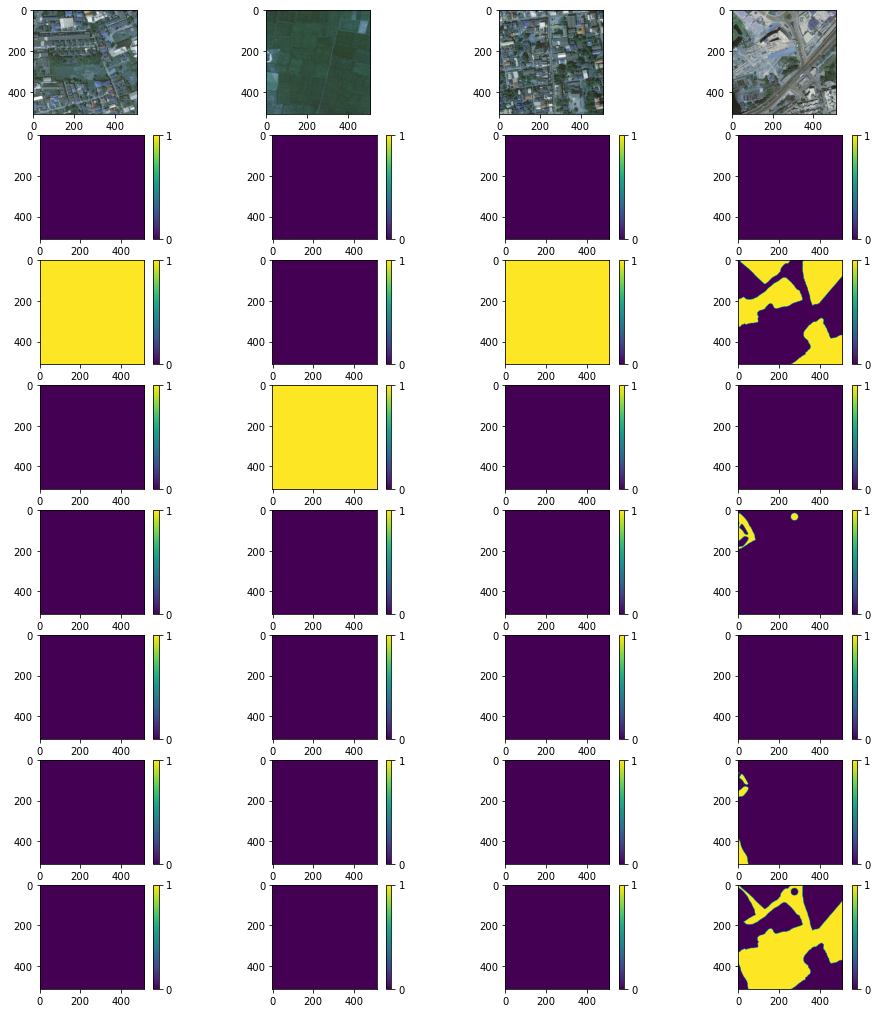

In [50]:
fig, axes = plt.subplots(8, 4, figsize=(16, 18))
# fig.subplots_adjust(hspace=0.1)
batch = 20
for a in np.arange(0,4):
    
    image = train_generator[batch][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[batch][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    
    for i in range(mask.shape[2]):
        r = axes[i+1, a].imshow(mask[:,:,i], vmin = 0, vmax = 1)
        cbar = fig.colorbar(r, ax = axes[i+1, a], ticks=[0,1])
#         d.clim(0,1)
mask.shape

In [6]:
BATCH_SIZE = 120
LR = 0.0001
EPOCHS = 15

n_classes = 7  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
activation = 'softmax'
#create model
model = sm.Unet(classes=n_classes, activation=activation)

In [7]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_1.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]



In [8]:
from datetime import datetime
start = datetime.now()
 

history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_generator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    use_multiprocessing=True
)


end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Epoch 1/15
21/69 [========>.....................] - ETA: 8:43:52 - loss: 0.9371 - iou_score: 0.0158 - f1-score: 0.0302

InvalidArgumentError:  Incompatible shapes: [120,512,512,7] vs. [61,512,512,7]
	 [[node dice_loss_plus_1focal_loss/mul (defined at /home/juanp.montoya/anaconda3/envs/NN/lib/python3.8/site-packages/segmentation_models/base/functional.py:145) ]] [Op:__inference_train_function_4473]

Errors may have originated from an input operation.
Input Source operations connected to node dice_loss_plus_1focal_loss/mul:
 IteratorGetNext (defined at <ipython-input-8-bd95b45ccc2f>:5)

Function call stack:
train_function


In [54]:
model.save("../random/model_output5.h5")

In [63]:
def plot_history(history):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss'] 
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

In [65]:
plot_history(model.history)

KeyError: 'iou_score'

In [67]:
val_check =  model.predict(val_generator[1][0])

In [74]:
image

array([[64., 63., 56., ..., 56., 51., 55.],
       [48., 59., 54., ..., 48., 50., 49.],
       [54., 68., 51., ..., 53., 56., 54.],
       ...,
       [28., 12., 43., ..., 68., 56., 36.],
       [27., 23., 35., ..., 65., 47., 40.],
       [36., 44., 42., ..., 64., 60., 63.]], dtype=float32)

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(16, 18))
# fig.subplots_adjust(hspace=0.1)
batch = 20
for a in np.arange(0,4):
    
    image = val_generator[1][0][a + 5 , :,:,:]

    # Load masks
    mask = val_check[a+5,:,:,]
    axes[0, a].imshow( image)
    print(mask.shape)
    for i in range(mask.shape[2]):
        r = axes[i+1, a].imshow(mask[:,:,i], vmin = 0, vmax = 1)
        cbar = fig.colorbar(r, ax = axes[i+1, a], ticks=[0,1])
#         d.clim(0,1)
mask.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
